В этом блокноте я честно высчитываю, а какое же качество дают модели, сжатые в соседнем блокноте compressions.ipynb

Для запуска могут потребоваться библиотеки, не указанные в requirements. 

# Готовим функции-оценивалки

In [1]:
original_path = 'C:/Users/ddale/Downloads/NLP/rusvectores/model.model'
exp_path = 'C:/Users/ddale/Downloads/NLP/compress_ft/'

In [2]:
import os
import sys

def add_sys_path(p):
    p = os.path.abspath(p)
    if p not in sys.path:
        sys.path.append(p)

add_sys_path('..')

In [3]:
import gensim
import pandas as pd
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import roc_auc_score

In [106]:
from importlib import reload
import compress_fasttext.evaluation
reload(compress_fasttext.evaluation);

In [4]:
from compress_fasttext.evaluation import cosine, vocabulary_from_files, make_evaluator

from compress_fasttext.utils import mb

In [5]:
hj = pd.read_csv('../data/word_similarity/hj.csv', encoding='utf-8')
simlex = pd.read_csv('../data/word_similarity/ru_simlex965.tsv', encoding='utf-8', sep='\t')
rt = pd.read_csv('../data/word_similarity/rt-test.csv', encoding='utf-8')
ae2 = pd.read_csv('../data/word_similarity/ae2-test.csv', encoding='utf-8')

In [107]:
small_vocab = list(vocabulary_from_files('../data/toy_corpora/').keys())

In [7]:
def produce_ws(model, words1, words2):
    def emb(w):
        if w in model:
            return model[w]
        return model['да'] * 0
    return [cosine(emb(w1), emb(w2)) for w1, w2 in zip(words1, words2)]

def evaluate_ws(model, dataset, metric=lambda x,y: spearmanr(x,y).correlation):
    ws = produce_ws(model, dataset.word1, dataset.word2)
    return metric(dataset.sim, ws)


In [8]:
def eval_hj(model):
    return evaluate_ws(model, hj, metric=lambda x,y: spearmanr(x,y).correlation)

def eval_sl(model):
    return evaluate_ws(model, simlex, metric=lambda x,y: spearmanr(x,y).correlation)

def eval_rt(model):
    return evaluate_ws(model, rt, metric=lambda x,y: roc_auc_score(x,y)*2-1)

def eval_ae(model):
    return evaluate_ws(model, ae2, metric=lambda x,y: roc_auc_score(x,y)*2-1)

In [124]:
import time

small_vocab = list(vocabulary_from_files('../data/toy_corpora/').keys())

def time_per_word(model, vocab=small_vocab, runs=10):
    t = time.time()
    for r in range(runs):
        for w in vocab:
            emb = model[w]
    td = time.time() - t
    return td / len(vocab) / runs

In [11]:
big_ft = gensim.models.fasttext.FastTextKeyedVectors.load(original_path)
big_ft.adjust_vectors()

In [98]:
from compress_fasttext.evaluation import vecs_similarity

In [134]:
from pymorphy2 import MorphAnalyzer
morphAnalyzer = MorphAnalyzer()

def w2lemma(w):
    parsed = morphAnalyzer.parse(w)
    if not parsed:
        return w
    nf = parsed[0].normal_form.replace('ё', 'е')
    return nf or w

In [135]:
small_vocab_lemmas = list({w2lemma(w) for w in small_vocab})

In [142]:
def load_words(fn):
    with open(fn, 'r', encoding='utf-8') as f:
        return [w.strip() for w in f.readlines()]

In [144]:
taiga_in = load_words('../data/model_vocab/taiga_social_in_vocab.txt')
taiga_out = load_words('../data/model_vocab/taiga_social_out_of_vocab.txt')
taiga_all = taiga_in + taiga_out

In [157]:
import time

def time_per_word(model, vocab=taiga_all, runs=1):
    t = time.time()
    for r in range(runs):
        for w in vocab:
            emb = model[w]
    td = time.time() - t
    return td / len(vocab) / runs

In [136]:
cossim_raw = lambda model: vecs_similarity(big_ft, model, small_vocab)
cossim_lemma = lambda model: vecs_similarity(big_ft, model, small_vocab_lemmas)

In [158]:
def evaluate_all(model):
    result = {
        'time': time_per_word(model),
        'hj': eval_hj(model),
        'ae': eval_ae(model),
        'rt': eval_rt(model),
        'sl': eval_sl(model),
        'ram': mb(model),
        'cs_raw': cossim_raw(model),
        'cs_lemma': cossim_lemma(model),
        'cs_all': vecs_similarity(big_ft, model, taiga_all),
        'cs_in': vecs_similarity(big_ft, model, taiga_in),
        'cs_out': vecs_similarity(big_ft, model, taiga_out),
    }
    return result

In [161]:
evaluate_all(big_ft)

{'time': 7.954563707370537e-05,
 'hj': 0.666836541489121,
 'ae': 0.8251780625041887,
 'rt': 0.722727176198263,
 'sl': 0.33173090831758584,
 'ram': 2723.8586988449097,
 'cs_raw': 0.9999999998682989,
 'cs_lemma': 0.9999999984703485,
 'cs_all': 0.9999999997035213,
 'cs_in': 0.9999999999104886,
 'cs_out': 0.9999999992787422,
 'tpw': 5.626038647139459e-05}

In [159]:
evaluate_all(gensim.models.fasttext.FastTextKeyedVectors.load(exp_path + 'ft_freqprune_100K_20K_pq_100.bin'))

{'time': 0.0007173205173673311,
 'hj': 0.6434756391067323,
 'ae': 0.7941962742138151,
 'rt': 0.6986646878804668,
 'sl': 0.3228528639335229,
 'ram': 28.393406867980957,
 'cs_raw': 0.9666984405828691,
 'cs_lemma': 0.9691338860611208,
 'cs_all': 0.9615299586447199,
 'cs_in': 0.9638957046495806,
 'cs_out': 0.9566745147706934,
 'tpw': 0.0005215796782408759}

In [162]:
((0.6434/0.6668) + (0.7941/0.8251) + (0.6986/0.7227) + (0.3228/ 0.3317)) / 4

0.9667892926371568

## ещё немножко аналитики

In [18]:
import numpy as np

In [137]:
print(np.mean([w in big_ft.vocab for w in small_vocab]))
print(np.mean([w in big_ft.vocab for w in small_vocab_lemmas]))

0.3494071146245059
0.9634703196347032


In [139]:
len(set(small_vocab))

1265

In [140]:
for dataset in [hj, rt, simlex, ae2]:
    v = set(dataset.word1).union(set(dataset.word2))
    print(len(v), np.mean([w in big_ft.vocab for w in v]))

451 0.9800443458980045
8359 0.8906567771264505
1057 0.9981078524124882
2750 0.9570909090909091


## Разбираемся с `adjust_vectors`

In [21]:
orig_ft = gensim.models.fasttext.FastTextKeyedVectors.load(original_path)

In [29]:
e0 = evaluate_all(orig_ft)
e1 = evaluate_all(big_ft)

Грустный факт: после применения операции `adjust_vectors` (которая, теоретически, не должна аффектить ничего вообще!), перформанс на downstream задачках резко снижается. 

Значит: мне нужно обучить свой фасттекст. Который был бы достаточно свеж, достаточно хорош, и не ломался. 

In [31]:
pd.DataFrame({'raw': e0, 'adjust': e1}).T

,time,hj,ae,rt,sl,ram,cs,tpw
raw,0.000062,0.714388,0.910000,0.797292,0.394348,2723.858699,0.958159,0.000055
adjust,0.000044,0.666837,0.825178,0.722727,0.331731,2723.858699,1.000000,0.000040


# Оцениваем всё

In [44]:
def ft_disk_size(path):
    s = os.stat(path).st_size
    dn = os.path.dirname(path)
    bn = os.path.basename(path)
    for fn in os.listdir(dn):
        if fn.startswith(bn + '.'):
            s += os.stat(os.path.join(dn,fn)).st_size
    return s / 1024**2

In [163]:
all_metrics = {}

for fn in os.listdir(exp_path):
    if not fn.endswith('bin'): continue
    print(fn)
    the_model = gensim.models.fasttext.FastTextKeyedVectors.load(exp_path + fn)
    gc.collect()
    the_metrics = evaluate_all(the_model)
    the_metrics['disk'] = ft_disk_size(exp_path + fn)
    all_metrics[fn] = the_metrics

ft_dimred_10.bin
ft_dimred_100.bin
ft_dimred_150.bin
ft_dimred_25.bin
ft_dimred_5.bin
ft_dimred_50.bin
ft_fp16.bin
ft_fp16_ngrams.bin
ft_fp16_words.bin
ft_freqprune_100K_0K_pq_100.bin
ft_freqprune_100K_0K_pq_300.bin
ft_freqprune_100K_0K_pq_50.bin
ft_freqprune_100K_100K_pq_100.bin
ft_freqprune_100K_100K_pq_300.bin
ft_freqprune_100K_100K_pq_50.bin
ft_freqprune_100K_20K_pq_100.bin
ft_freqprune_100K_20K_pq_300.bin
ft_freqprune_100K_20K_pq_50.bin
ft_freqprune_100K_5K_pq_100.bin
ft_freqprune_100K_5K_pq_300.bin
ft_freqprune_100K_5K_pq_50.bin
ft_freqprune_400K_0K_pq_100.bin
ft_freqprune_400K_0K_pq_300.bin
ft_freqprune_400K_0K_pq_50.bin
ft_freqprune_400K_100K_pq_100.bin
ft_freqprune_400K_100K_pq_300.bin
ft_freqprune_400K_100K_pq_50.bin
ft_freqprune_400K_20K_pq_100.bin
ft_freqprune_400K_20K_pq_300.bin
ft_freqprune_400K_20K_pq_50.bin
ft_freqprune_400K_5K_pq_100.bin
ft_freqprune_400K_5K_pq_300.bin
ft_freqprune_400K_5K_pq_50.bin
ft_freqprune_50K_0K_pq_100.bin
ft_freqprune_50K_0K_pq_300.bin
ft_freqp

In [164]:
orig_metrics = evaluate_all(big_ft)
orig_metrics['disk'] = ft_disk_size(original_path)
all_metrics['original'] = orig_metrics

In [165]:
import re

def name2type(text):
    if text == 'original': 
        return 'original'
    if text == 'ft_fp16.bin': 
        return 'original fp16'
    if text == 'ft_fp16_words.bin': 
        return 'original fp16_w/o ngrams'
    if text == 'ft_fp16_ngrams.bin': 
        return 'original fp16 w/o words'
    if re.match('ft_dimred_\d+.bin', text):
        return 'decomposition'
    if re.match('ft_pq_\d+.bin', text):
        return 'pq'
    if re.match('ft_trim_[\d\.]+.bin', text):
        return 'prune hash'
    if re.match('ft_prune_freq_[\d\.]+.bin', text):
        return 'prune by freq'
    if re.match('ft_freqprune_\d+K_\d+K_pq_\d+.bin', text):
        return 'prune by freq + pq'
    return '-'

In [166]:
metrics_df = pd.DataFrame(all_metrics).T
metrics_df['compression'] = [name2type(name) for name in metrics_df.index]
metrics_df

,time,hj,ae,rt,sl,ram,cs_raw,cs_lemma,cs_all,cs_in,cs_out,tpw,disk,compression
ft_dimred_10.bin,0.000063,0.306962,0.569504,0.468071,0.072610,83.163209,0.555598,0.543999,0.596796,0.607247,0.575344,0.000103,71.563974,decomposition
ft_dimred_100.bin,0.000613,0.612102,0.818748,0.714748,0.264181,455.015397,0.828024,0.814135,0.869100,0.870880,0.865447,0.000644,625.267717,decomposition
ft_dimred_150.bin,0.000689,0.632550,0.826107,0.720873,0.294689,661.599946,0.885716,0.875845,0.917609,0.919589,0.913547,0.000763,932.830118,decomposition
ft_dimred_25.bin,0.000119,0.491934,0.721918,0.624718,0.156860,145.138574,0.661142,0.641210,0.708316,0.711149,0.702501,0.000049,163.863709,decomposition
ft_dimred_5.bin,0.000042,0.172029,0.395707,0.253708,0.026473,62.504754,0.464332,0.482884,0.505450,0.532352,0.450235,0.000044,40.824168,decomposition
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ft_trim_0.1.bin,0.000084,0.649073,0.798211,0.697014,0.325257,128.473850,0.963520,0.984084,0.952722,0.965373,0.926757,0.000091,129.556684,prune hash
ft_trim_0.2.bin,0.000078,0.663168,0.816040,0.717777,0.331474,257.071957,0.983515,0.993900,0.978646,0.988492,0.958438,0.000053,259.133737,prune hash
ft_trim_0.5.bin,0.000035,0.666709,0.824082,0.722336,0.331414,640.818283,0.996115,0.995518,0.994969,0.999022,0.986650,0.000034,624.438000,prune hash
ft_trim_1.0.bin,0.000026,0.667127,0.825072,0.722737,0.331730,1280.666779,0.999661,0.996586,0.998985,1.000000,0.996901,0.000027,1248.998929,prune hash


In [170]:
metrics_df.compression.value_counts()

prune by freq + pq          36
prune hash                  10
prune by freq               10
pq                           7
decomposition                6
original                     1
original fp16                1
original fp16 w/o words      1
original fp16_w/o ngrams     1
Name: compression, dtype: int64

In [352]:
metrics_df[metrics_df.compression=='prune by freq']

,time,hj,ae,rt,sl,ram,cs_raw,cs_lemma,cs_all,cs_in,cs_out,tpw,disk,compression,ie_rel
ft_prune_freq_0.001.bin,0.000154,0.042261,-0.000489,0.315085,0.084932,0.445371,0.359854,0.422390,0.438779,0.449998,0.415753,0.000089,0.577118,prune by freq,0.188644
ft_prune_freq_0.002.bin,0.000090,0.083426,0.006789,0.326339,0.116965,0.892259,0.460157,0.519732,0.512953,0.517642,0.503327,0.000090,1.155890,prune by freq,0.234292
ft_prune_freq_0.005.bin,0.000099,0.163620,0.094682,0.366317,0.129508,2.280522,0.578735,0.638897,0.609398,0.607063,0.614191,0.000091,2.892029,prune by freq,0.314208
ft_prune_freq_0.01.bin,0.000091,0.300497,0.219187,0.405124,0.149695,4.568181,0.664091,0.751320,0.684610,0.679859,0.694360,0.000128,5.787065,prune by freq,0.431789
ft_prune_freq_0.02.bin,0.000131,0.441979,0.439137,0.477894,0.190818,9.142873,0.768629,0.845656,0.766493,0.762360,0.774974,0.000092,11.575442,prune by freq,0.607499
ft_prune_freq_0.05.bin,0.000089,0.576663,0.687602,0.588766,0.288918,22.656610,0.887248,0.937659,0.871380,0.872023,0.870059,0.000091,28.938190,prune by freq,0.845394
ft_prune_freq_0.1.bin,0.000078,0.627669,0.772888,0.667985,0.323734,45.444650,0.951612,0.976750,0.936016,0.940549,0.926712,0.000108,57.872791,prune by freq,0.943938
ft_prune_freq_0.2.bin,0.000088,0.663341,0.809064,0.710039,0.331692,91.021409,0.984796,0.991308,0.977369,0.982679,0.966473,0.000064,115.729861,prune by freq,0.988789
ft_prune_freq_0.5.bin,0.000040,0.666845,0.822054,0.721300,0.331824,224.453115,0.997907,0.995327,0.996012,0.998813,0.990263,0.000043,242.121881,prune by freq,0.998027
ft_prune_freq_1.0.bin,0.000031,0.667182,0.825082,0.722740,0.331731,447.943208,0.999661,0.996574,0.999030,1.000000,0.997040,0.000030,484.452763,prune by freq,0.999498


In [323]:
metrics_df['ie_rel'] = np.mean([metrics_df[m] / metrics_df[m].max() for m in ['hj', 'sl', 'rt', 'ae']], axis=0) 

In [324]:
metrics_df.to_pickle('metrics.pkl')

In [354]:
metrics_df.to_csv('metrics.tsv')

### efficiency

In [186]:
mixed = metrics_df[metrics_df.compression=='prune by freq + pq'].copy().sort_values('ram', ascending=True)

In [188]:
mixed['cs_best'] = mixed['cs_all'].cummax()
mixed['cs_eff'] = mixed.cs_all / mixed.cs_best

In [190]:
mixed[mixed.cs_eff > 0.999]

,time,hj,ae,rt,sl,ram,cs_raw,cs_lemma,cs_all,cs_in,cs_out,tpw,disk,compression,cs_best,cs_eff
ft_freqprune_50K_0K_pq_50.bin,0.000242,0.510857,0.558700,0.583388,0.225123,8.140435,0.850727,0.800707,0.855098,0.850806,0.863907,0.000305,4.852679,prune by freq + pq,0.855098,1.0
ft_freqprune_50K_5K_pq_50.bin,0.000330,0.596431,0.668571,0.615103,0.275432,10.317487,0.877184,0.877573,0.862623,0.861826,0.864258,0.000330,6.405070,prune by freq + pq,0.862623,1.0
ft_freqprune_50K_0K_pq_100.bin,0.000383,0.546036,0.608255,0.617548,0.256702,10.524812,0.917583,0.867805,0.920153,0.914489,0.931777,0.000256,8.417727,prune by freq + pq,0.920153,1.0
ft_freqprune_50K_5K_pq_100.bin,0.000250,0.617538,0.713026,0.640740,0.293197,12.940473,0.943174,0.943386,0.927278,0.925012,0.931928,0.000260,10.324877,prune by freq + pq,0.927278,1.0
ft_freqprune_50K_20K_pq_100.bin,0.000204,0.639476,0.782964,0.683601,0.323163,18.454968,0.951885,0.964652,0.940943,0.945288,0.932026,0.000504,13.388101,prune by freq + pq,0.940943,1.0
ft_freqprune_100K_0K_pq_100.bin,0.000349,0.608875,0.708369,0.680599,0.267058,20.463250,0.940816,0.897626,0.950067,0.946839,0.956694,0.000320,16.029263,prune by freq + pq,0.950067,1.0
ft_freqprune_100K_5K_pq_100.bin,0.000403,0.628626,0.764922,0.679837,0.296264,22.878911,0.961159,0.956168,0.954935,0.953915,0.957030,0.000446,17.899714,prune by freq + pq,0.954935,1.0
ft_freqprune_100K_20K_pq_100.bin,0.000427,0.643476,0.794196,0.698665,0.322853,28.393407,0.966698,0.969134,0.961530,0.963896,0.956675,0.000716,20.972652,prune by freq + pq,0.961530,1.0
ft_freqprune_100K_0K_pq_300.bin,0.000371,0.613326,0.720925,0.683240,0.268368,39.537526,0.963732,0.921186,0.972052,0.968254,0.979845,0.000417,44.590389,prune by freq + pq,0.972052,1.0
ft_freqprune_100K_5K_pq_300.bin,0.000443,0.640352,0.773815,0.687454,0.304946,42.907651,0.982773,0.975343,0.976234,0.974470,0.979854,0.000303,47.869340,prune by freq + pq,0.976234,1.0


In [200]:
mixed['ngram_size'] = mixed.index.to_series().apply(lambda x: int(x.split('_')[2][:-1]))
mixed['words_size'] = mixed.index.to_series().apply(lambda x: int(x.split('_')[3][:-1]))
mixed['pq_dim'] = mixed.index.to_series().apply(lambda x: int(x.split('_')[5].split('.')[0]))

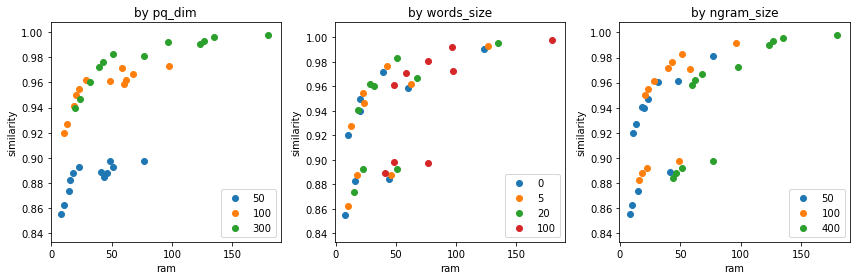

In [250]:
plt.figure(figsize=(12,4))
for i, var in enumerate(['pq_dim', 'words_size', 'ngram_size']):
    plt.subplot(1, 3, i+1)
    l = []
    plt.set_cmap('viridis')
    for a, b in mixed.groupby(var):
        l.append(a)
        plt.scatter(b.ram, b.cs_all, cmap=plt.cm.Greens)
    plt.legend(l, loc='lower right')
    plt.title('by ' + var)
    plt.xlabel('ram')
    plt.ylabel('similarity')
plt.tight_layout();

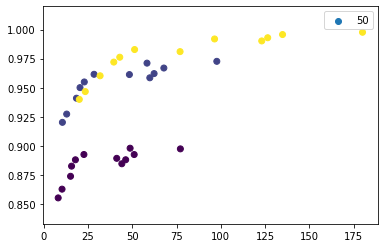

In [245]:
plt.scatter(mixed.ram, mixed.cs_all, c=mixed.pq_dim);
plt.legend(mixed.pq_dim.unique())

In [316]:
metrics_df[metrics_df.index.to_series().str.contains('fp16')]

,time,hj,ae,rt,sl,ram,cs_raw,cs_lemma,cs_all,cs_in,cs_out,tpw,disk,compression
ft_fp16.bin,0.000034,0.666781,0.825175,0.722725,0.331730,1280.666779,1.000000,1.000000,1.000000,1.000000,1.0,0.000049,1248.998929,original fp16
ft_fp16_ngrams.bin,0.000106,0.643272,0.783875,0.712722,0.287364,1144.410919,0.987800,0.962324,0.994094,0.991217,1.0,0.000127,1144.409912,original fp16 w/o words
ft_fp16_words.bin,0.000050,0.614175,0.706711,0.413179,0.328931,136.258077,0.349407,0.963470,0.672388,1.000000,0.0,0.000044,104.590613,original fp16_w/o ngrams


In [326]:
metrics2 = metrics_df[
    (metrics_df.compression!='prune by freq + pq') & (metrics_df.ram > 5)
    | metrics_df.index.to_series().apply(lambda x: mixed.cs_eff.get(x, 0) > 0.999)
].copy()

## Plot everything

In [276]:
import matplotlib.pyplot as plt
%matplotlib inline

In [335]:
labels = [
    'decomposition', 
    'pq', 
    'prune hash',
    'prune by freq', 
    'prune by freq + pq', 
    'original', 
    'original fp16', 
    'original fp16 w/o words', 
    'original fp16_w/o ngrams',
]

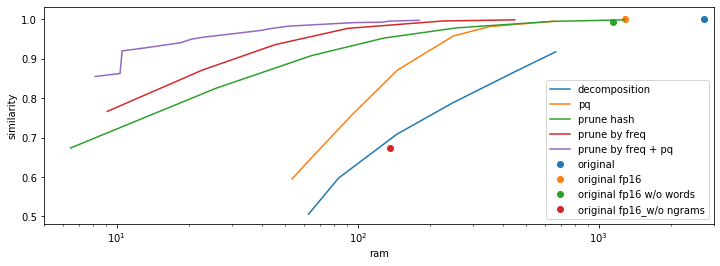

In [329]:
def grouped_plot(data, x='ram', y='cs_all', by='compression', scatter=False, labels=None, legend=True):
    if labels is None:
        labels = data[by].unique()
    for key in labels:
        filtered = data[data[by] == key].sort_values(x)
        plotter = plt.scatter
        if not scatter and filtered.shape[0] > 1:
            plotter = plt.plot
        plotter(filtered[x], filtered[y])
    if legend:
        plt.legend(labels)

plt.figure(figsize=(12, 4))
grouped_plot(metrics2, x='ram', y='cs_all', labels=labels)
plt.xscale('log');
plt.xlim([5, 3000])

plt.xlabel('ram')
plt.ylabel('similarity');

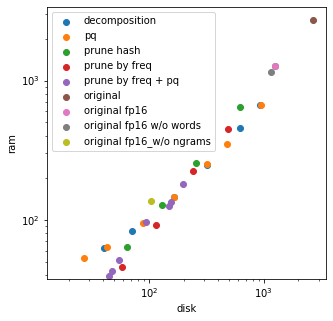

In [284]:
plt.figure(figsize=(5,5))
for key in labels:
    filtered = metrics2[metrics2['compression'] == key]
    plt.scatter(filtered['disk'], filtered['ram'])
plt.legend(labels)
    
plt.xscale('log')
plt.yscale('log')

plt.xlabel('disk')
plt.ylabel('ram');

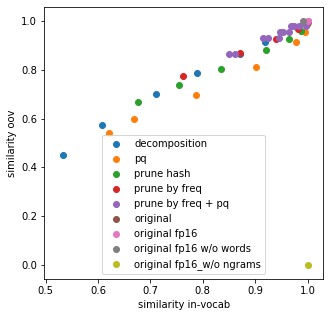

In [342]:
plt.figure(figsize=(5,5))
for key in labels:
    filtered = metrics2[metrics2['compression'] == key]
    plt.scatter(filtered['cs_in'], filtered['cs_out'])
plt.legend(labels)

plt.xlabel('similarity in-vocab')
plt.ylabel('similarity oov');

In [289]:
metrics2.columns

Index(['time', 'hj', 'ae', 'rt', 'sl', 'ram', 'cs_raw', 'cs_lemma', 'cs_all',
       'cs_in', 'cs_out', 'tpw', 'disk', 'compression'],
      dtype='object')

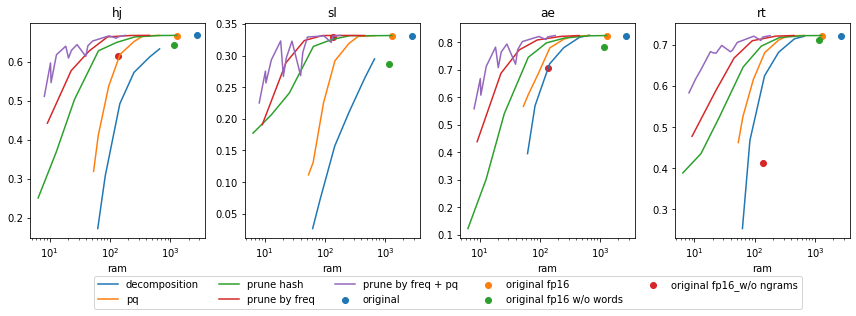

In [314]:
f = plt.figure(figsize=(12, 4))
for i, me in enumerate(['hj', 'sl', 'ae', 'rt']):
    plt.subplot(1, 4, i+1)
    grouped_plot(metrics2, x='ram', y=me, labels=labels, legend=False)
    plt.title(me)
    plt.xscale('log');
    plt.xlabel('ram')
plt.tight_layout()
plt.legend(labels, loc='lower center', ncol=5, bbox_to_anchor=(-1.3, -0.35));

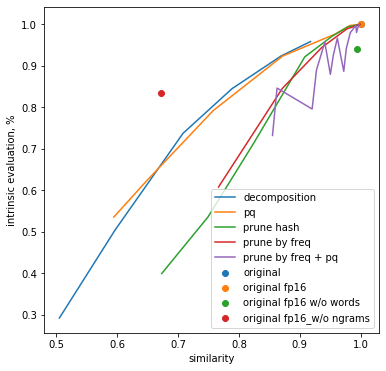

In [332]:
plt.figure(figsize=(6, 6))
grouped_plot(metrics2, x='cs_all', y='ie_rel', labels=labels)

plt.xlabel('similarity')
plt.ylabel('intrinsic evaluation, %');

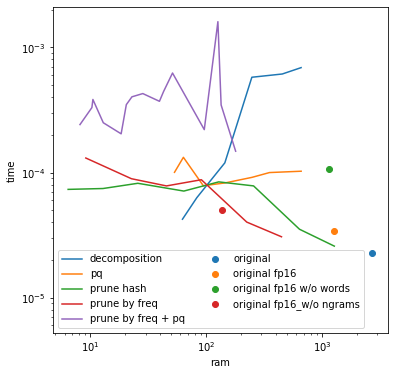

In [340]:
plt.figure(figsize=(6, 6))
grouped_plot(metrics2, x='ram', y='time', labels=labels, legend=None)
plt.legend(labels, ncol=2)

plt.yscale('log')
plt.xscale('log')
plt.xlabel('ram')
plt.ylabel('time');

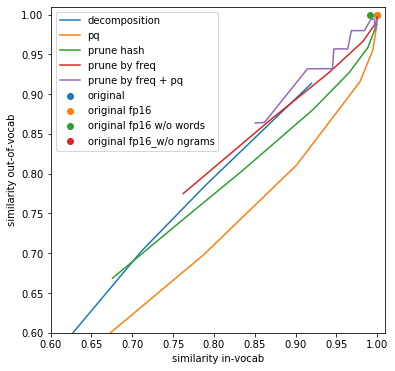

In [349]:
plt.figure(figsize=(6, 6))
grouped_plot(metrics2, x='cs_in', y='cs_out', labels=labels)

plt.xlim([0.6, 1.01])
plt.ylim([0.6, 1.01])
plt.xlabel('similarity in-vocab')
plt.ylabel('similarity out-of-vocab');